In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, IBMQ, assemble
from qiskit.providers.ibmq.job import job_monitor

provider = IBMQ.load_account()
backend = provider.backend.ibmq_lima

In [2]:
def get_basis_state(nqubit):
    if nqubit <= 0:
        print("nqubit should be greater than 0")
        return 0
    
    if nqubit > 1:
        tmp1 = ['0' + i for i in get_basis_state(nqubit-1)]
        tmp2 = ['1' + i for i in get_basis_state(nqubit-1)]
        return tmp1 + tmp2
    if nqubit == 1:
        return ['0', '1']

In [3]:
def calibrate_experiment(basis_state):
    qasmString = ['OPENQASM 2.0;\n',
                  'include "qelib1.inc";\n', 
                  '\n', 
                  'qreg q[' + str(len(basis_state)) + '];\n', 
                  'creg c[' + str(len(basis_state)) + '];\n', 
                  '\n']
    tmp = basis_state[-1::-1]
    for i in range(len(tmp)):
        if tmp[i] == '0':
            qasmString.append('id q[' + str(i) + '];\n')
        if tmp[i] == '1':
            qasmString.append('x q[' + str(i) + '];\n')
    for i in range(len(tmp)):
        qasmString.append('measure q[' + str(i) + '] -> c[' + str(i) + '];\n')
    
    f = open('./calibrate/' + basis_state + '.txt', 'w')
    f.writelines(qasmString)
    f.close()
    return qasmString

In [4]:
def run_calibration(basis_state, jobName):
    circList = []
    for i in range(len(basis_state)):
        circList.append(QuantumCircuit.from_qasm_file('./calibrate/' + basis_state[i] + '.txt'))
    
    transpiled = transpile(circList, backend=backend)
    #qobj = assemble(transpiled, backend=backend) # Avoid Warning
    job = backend.run(transpiled, job_name= jobName, shots = 20000)
    #job_monitor(job)
    return job.job_id()

In [5]:
basis_state = get_basis_state(5)
basis_state

['00000',
 '00001',
 '00010',
 '00011',
 '00100',
 '00101',
 '00110',
 '00111',
 '01000',
 '01001',
 '01010',
 '01011',
 '01100',
 '01101',
 '01110',
 '01111',
 '10000',
 '10001',
 '10010',
 '10011',
 '10100',
 '10101',
 '10110',
 '10111',
 '11000',
 '11001',
 '11010',
 '11011',
 '11100',
 '11101',
 '11110',
 '11111']

In [ ]:
for state in basis_state:
    calibrate_experiment(state)
    
run_calibration(basis_state, 'lima_calibrate')

In [6]:
def get_response_matrix(data, nqubit):
    """
    Be careful for the row and column of response matrix
    """
    basis_state = get_basis_state(nqubit)
    size = len(basis_state)
    response = np.zeros((size,size)) * np.nan
    for i in range(size): 
        for j in range(size):
            state = basis_state[j]
            try: 
                response[i][j] = data[i][state]
            except KeyError:
                response[i][j] = 0
    
    return response

In [7]:
job_id = '61d64935a90e53713073287b'
data = backend.retrieve_job('61d64935a90e53713073287b').result().get_counts()

<AxesSubplot:>

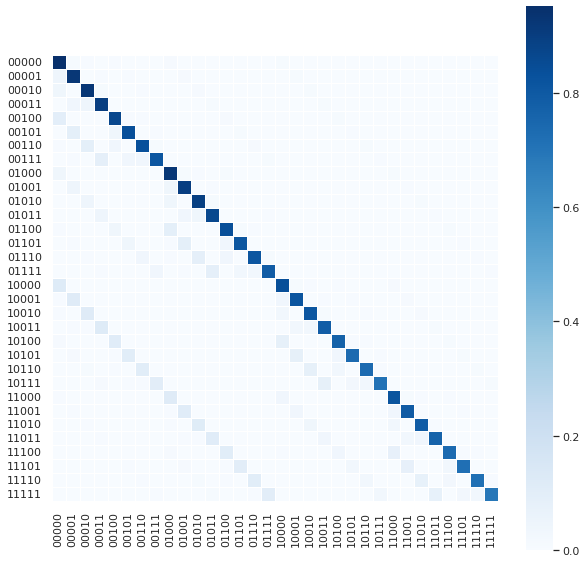

In [8]:
import seaborn as sns
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(
    get_response_matrix(data, 5)/20000,
    cmap=sns.color_palette("Blues", as_cmap=True),
    linewidths=.5,
    xticklabels = basis_state,
    yticklabels = basis_state,
    square = True
)